In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import random
import string
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# Import nltk package 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bblu2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bblu2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bblu2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# import the datasets
dfRecipes = pd.read_csv("RAW_recipes.csv")

In [6]:
# correcting data types
dfRecipes['submitted'] = pd.to_datetime(dfRecipes.submitted)
dfRecipes['n_steps'] = dfRecipes.n_steps.astype('int')

# dropping columns with nan values in description and name
dfRecipes.dropna(axis=0, inplace=True)

# dropping an outlier
dfRecipes = dfRecipes[dfRecipes.minutes < max(dfRecipes.minutes)]

In [7]:
dfRecipesNew = dfRecipes[['name', 'id', 'description', 'ingredients']]

In [8]:
df = dfRecipesNew

In [9]:
df.iloc[0]

name                  arriba   baked winter squash mexican style
id                                                        137739
description    autumn is my favorite time of year to cook! th...
ingredients    ['winter squash', 'mexican seasoning', 'mixed ...
Name: 0, dtype: object

In [10]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

def preprocess(string): 
    string = string.replace('\n', ' ')
    string = re.sub(r'[^\w\s]|_', ' ', string)
    string = re.sub(r'\s+', ' ', string).lower().strip()

    string = word_tokenize(string)
    string = [word for word in string if word.lower() not in stop_words]
    
    return string

In [11]:
def preprocesslist(string): 
    string = string.replace("'", '')
    string = string.replace("[", '')
    string = string.replace("]", '')
    string = string.replace(",", '')

    string = word_tokenize(string)
    
    return string

In [12]:
df['description'] = df.description.transform(preprocess)
df['ingredients'] = df.ingredients.transform(preprocesslist)

In [13]:
df.iloc[0]

name                  arriba   baked winter squash mexican style
id                                                        137739
description    [autumn, favorite, time, year, cook, recipe, p...
ingredients    [winter, squash, mexican, seasoning, mixed, sp...
Name: 0, dtype: object

In [36]:
description_word_count = defaultdict(int)
for i,r in df.iterrows():
    for w in r['description']:
        description_word_count[w] += 1

In [38]:
len(description_word_count)

69061

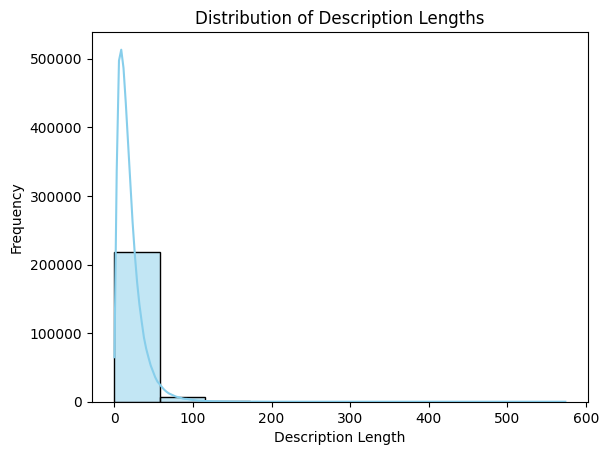

In [14]:
df['Description_Length'] = df['description'].str.len()

sns.histplot(data=df, x='Description_Length', bins=10, kde=True, color='skyblue')
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [15]:
df['Description_Length'].describe()

count    226656.000000
mean         19.724013
std          17.051615
min           0.000000
25%           8.000000
50%          15.000000
75%          26.000000
max         574.000000
Name: Description_Length, dtype: float64

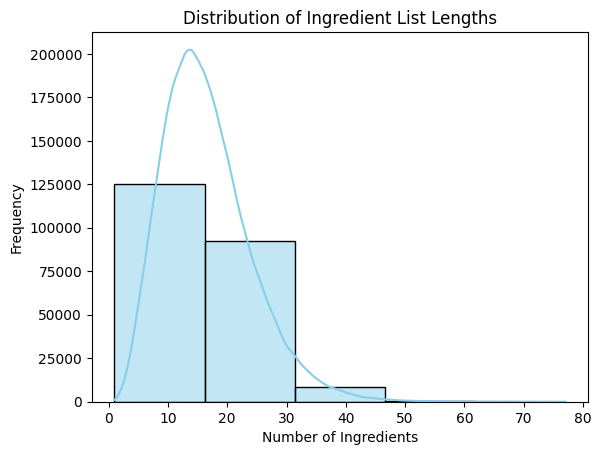

In [16]:
df['Ingredient_Length'] = df['ingredients'].apply(len)

sns.histplot(data=df, x='Ingredient_Length', bins=5, kde=True, color='skyblue')
plt.title('Distribution of Ingredient List Lengths')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

In [17]:
flavor_map = {
    "Malty": ["pork", "chicken", "sausage", "beet", "carrot", "caramel", "honey", "syrup", "brown sugar", "raisin", "date", "nutmeg", "cinnamon", "allspice", "gouda", "swiss", "mild", "cheddar"],
    "Hoppy": ["beef", "lamb", "sausage", "arugula", "endive", "lime", "lemon", "zest", "chili", "pepper", "jalapeno", "coriander", "parsley", "blue", "sharp", "cheddar", "parmesan"],
    "Crisp": ["shrimp", "fish", "oyster", "lobster", "clam", "lettuce", "vinaigrette", "grill", "chicken", "cucumber", "lime", "avocado", "mint", "dill", "pretzel", "cracker", "popcorn", "brie", "mozarella", "ricotta"],
    "Roasty": ["smoke", "brisket", "roast", "beef", "mushroom", "bbq", "dark", "chocolate", "coffee", "molasses", "toast", "nut", "pecan", "hazelnut", "clove", "star", "anise", "cardamom", "cheddar", "age", "gruyere"],
    "Fruity/Spicy": ["roast", "chicken", "salmon", "scallops", "pasta", "sphagetti", "fettucine", "orange", "lemon", "berry", "berries", "raspeberries", "raspberry", "blackberry", "blackberries", "ginger", "basil", "thyme", "cinnamon", "feta", "goat", "cheese"],
    "Sour": ["salami", "prosciutto", "shellfish", "clam", "oyster", "tart", "cranberry", "cranberries", "cherry", "cherries", "passionfruit", "nut", "pickle", "olive", "chevre", "feta"],
    "Rich/Hearty": ["duck", "short", "rib" "lamb", "roast", "vegetable", "butternut", "squash", "carrot", "caramel", "toffee", "fig", "prune", "rosemary", "sage", "bay", "leaf", "stilton", "age", "cheddar", "camembert"],
    "Smoky": ["smoke", "smoked", "salmon", "charred", "char" "vegetables", "eggplant", "bacon", "bell", "peppers", "bbq", "paprika", "chipotle", "thyme", "toast", "almonds", "peanuts", "gouda", "manchego"],
    "Specialty": ["turkey", "holiday", "fall", "winter", "ham", "squash", "spice", "pumpkin", "cranberry", "cranberries", "chocolate", "coffee", "cinnamon", "nutmeg", "clove", "vanilla", "cream", "cheese", "dessert", "havarti"]
}

In [18]:
def labelrecipe(row):
    flavor_count = {flavor: 0 for flavor in flavor_map.keys()}
    ingredients = row['ingredients']
    description = row['description']
    for word in ingredients:
        for flavor, thing in flavor_map.items():
            if word.lower() in thing:
                flavor_count[flavor] += 1
    for word in description:
        for flavor, thing in flavor_map.items():
            if word.lower() in thing:
                flavor_count[flavor] += 1

    return max(flavor_count, key=flavor_count.get)

In [19]:
df['Flavor'] = df.apply(labelrecipe, axis=1)

In [20]:
df['Flavor'].value_counts()

Flavor
Hoppy           70964
Specialty       45790
Malty           42705
Fruity/Spicy    34056
Crisp            9579
Roasty           9567
Smoky            5076
Rich/Hearty      4912
Sour             4007
Name: count, dtype: int64

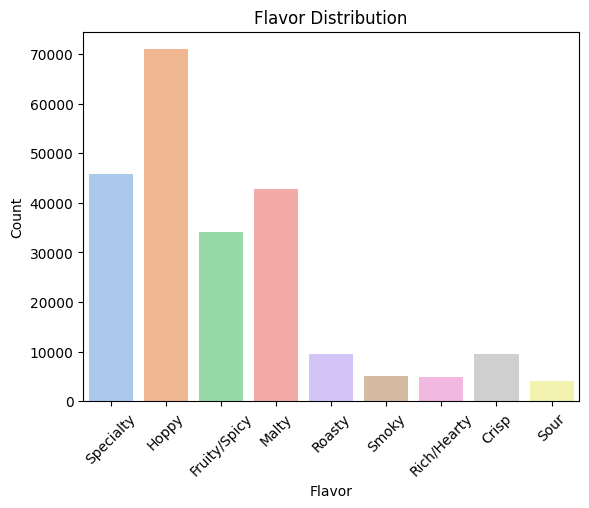

In [21]:
sns.countplot(data=df, x='Flavor', palette='pastel')
plt.title('Flavor Distribution')
plt.xlabel('Flavor')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [22]:
df.iloc[0]

name                         arriba   baked winter squash mexican style
id                                                               137739
description           [autumn, favorite, time, year, cook, recipe, p...
ingredients           [winter, squash, mexican, seasoning, mixed, sp...
Description_Length                                                   20
Ingredient_Length                                                    11
Flavor                                                        Specialty
Name: 0, dtype: object

In [23]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [24]:
splitRatio = 0.70
splitIndex = int(len(df) * splitRatio)
reviewTrain = shuffled_df.iloc[:splitIndex]
reviewTest = shuffled_df.iloc[splitIndex:]

reviewTrain.reset_index()
reviewTest.reset_index()

len(reviewTrain), len(reviewTest)

(158659, 67997)

In [25]:
wordCount = defaultdict(int)
for i, recipe in reviewTrain.iterrows():
    for w in recipe['ingredients']:
        wordCount[w] += 1
    for w in recipe['description']:
        wordCount[w] += 1
    #for w in recipe['tags']:
    #    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [26]:
words = [x[1] for x in counts[:1000]]

In [27]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    for w in datum['ingredients']:
        if w in words:
            feat[wordId[w]] += 1
    for w in datum['description']:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [28]:
X = [feature(d) for i,d in reviewTrain.iterrows()]
y = [d for d in reviewTrain['Flavor'].values]

In [29]:
modFoodLabel = linear_model.LogisticRegression(C=1)
modFoodLabel.fit(X, y)
theta = modFoodLabel.coef_
predictions = modFoodLabel.predict(X)

In [30]:
correct = [p == l for p,l in zip(predictions, reviewTrain['Flavor'].values)]
sum(correct) / len(correct)

0.9804045153442288

In [31]:
Xtest = [feature(d) for i, d in reviewTest.iterrows()]
ytest = [d['Flavor'] for i, d in reviewTest.iterrows()]

In [32]:
testPredictions = modFoodLabel.predict(Xtest)

In [33]:
correct = [p == l for p,l in zip(testPredictions, reviewTest['Flavor'].values)]
sum(correct) / len(correct)

0.9727046781475653

In [34]:
predicts = [(food,str(predict)) for food, predict in zip(reviewTest['name'].values, testPredictions)]


In [35]:
with open('foodFlavorPredict.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in predicts:
        writer.writerow([item])